<a href="https://colab.research.google.com/github/jesvin1/Basics/blob/master/Nifty_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html

#Time series analysis Importing the required packages

In [0]:
!pip install pmdarima
!pip install yfinance

     |████████████████████████████████| 1.5MB 1.8MB/s 


In [0]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
#from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import datetime as datetime
import yfinance as yf

#Load the Data

In [0]:
# sets the sample period as 5 years back from 09/12/2019
end = datetime.datetime(2020, 4, 1)
start = end - datetime.timedelta(days = 15*365)


In [0]:
# gets the closing price fo HDFC for the past 7 years
my_stock = yf.Ticker('^NSEI')
my_stock = pd.DataFrame(my_stock.history(start = start, end = end)['Close'])
my_stock = my_stock.rename(str.lower, axis = 'columns')
my_stock.head()

,close
Date,
2007-09-17,4494.65
2007-09-18,4546.20
2007-09-19,4732.35
2007-09-20,4747.55
2007-09-21,4837.55


##Checking for Stationarity

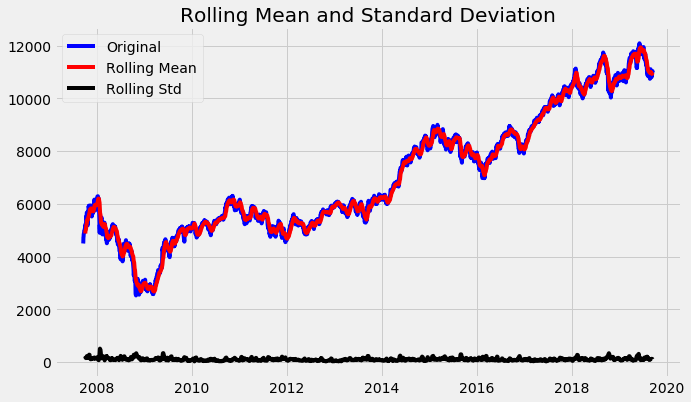

Results of dickey fuller test
Test Statistics                  -0.287236
p-value                           0.927293
No. of lags used                  7.000000
Number of observations used    2918.000000
critical value (1%)              -3.432593
critical value (5%)              -2.862531
critical value (10%)             -2.567298
dtype: float64


In [0]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(my_stock.close)

##Separate Trend and Seasonality from the time series



<Figure size 720x432 with 0 Axes>

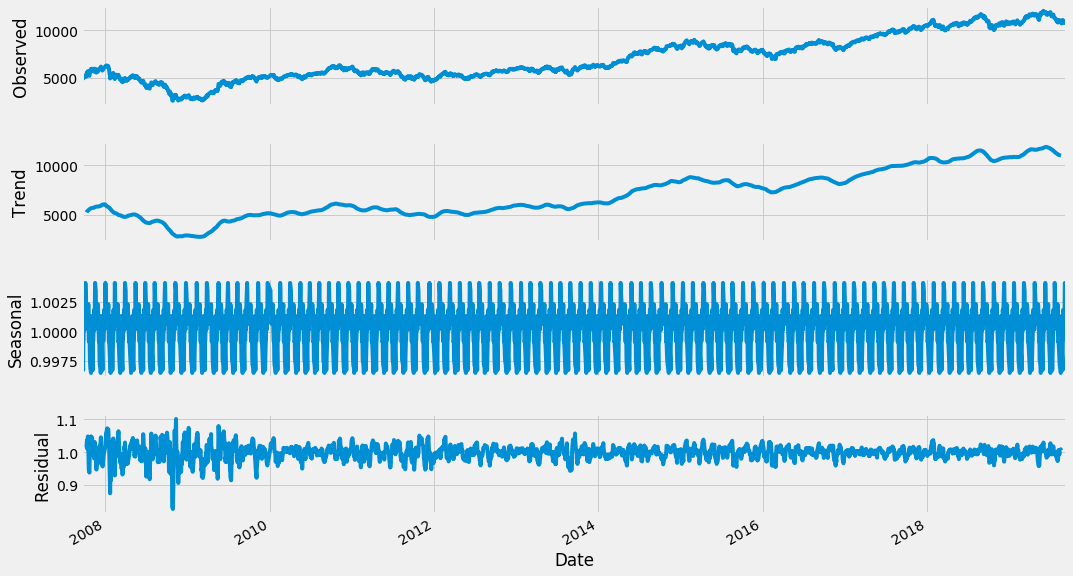

In [0]:
result = seasonal_decompose(my_stock, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


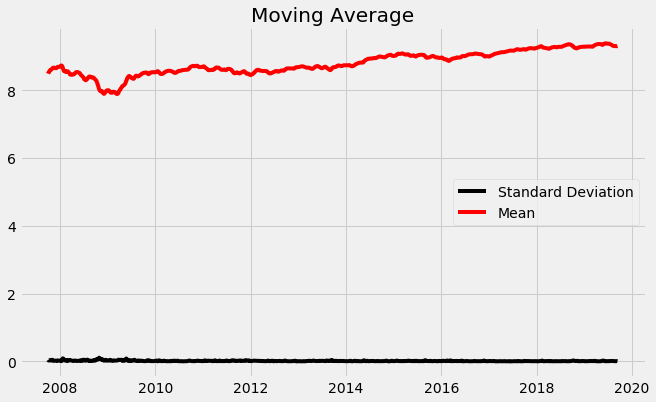

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(my_stock)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

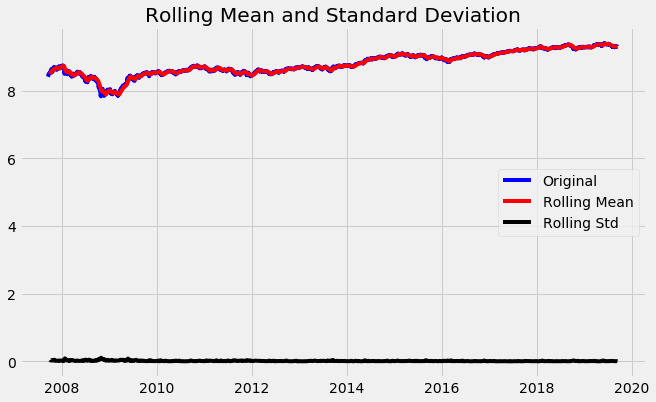

Results of dickey fuller test
Test Statistics                  -0.727837
p-value                           0.839407
No. of lags used                  7.000000
Number of observations used    2918.000000
critical value (1%)              -3.432593
critical value (5%)              -2.862531
critical value (10%)             -2.567298
dtype: float64


In [0]:
test_stationarity(df_log.close)

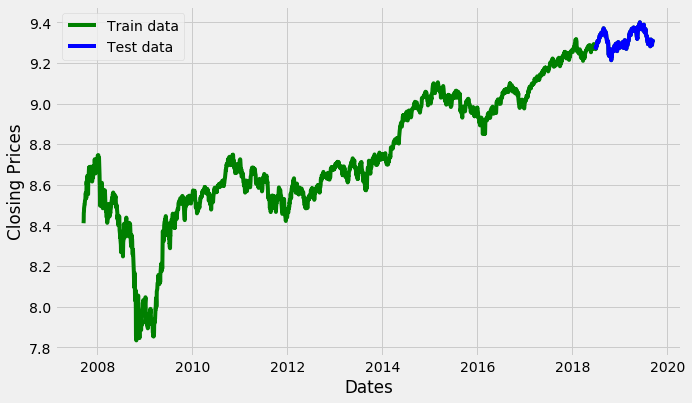

In [0]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.

In [0]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-14858.888, BIC=-14847.139, Time=0.506 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-14872.118, BIC=-14854.495, Time=0.464 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-14872.818, BIC=-14855.195, Time=0.925 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=-14859.672, BIC=-14853.798, Time=0.169 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-14871.221, BIC=-14847.723, Time=1.198 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-14871.600, BIC=-14848.102, Time=1.051 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-14869.808, BIC=-14840.437, Time=2.603 seconds
Total fit time: 6.939 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 2630
Model:               SARIMAX(0, 1, 1)   Log Likelihood

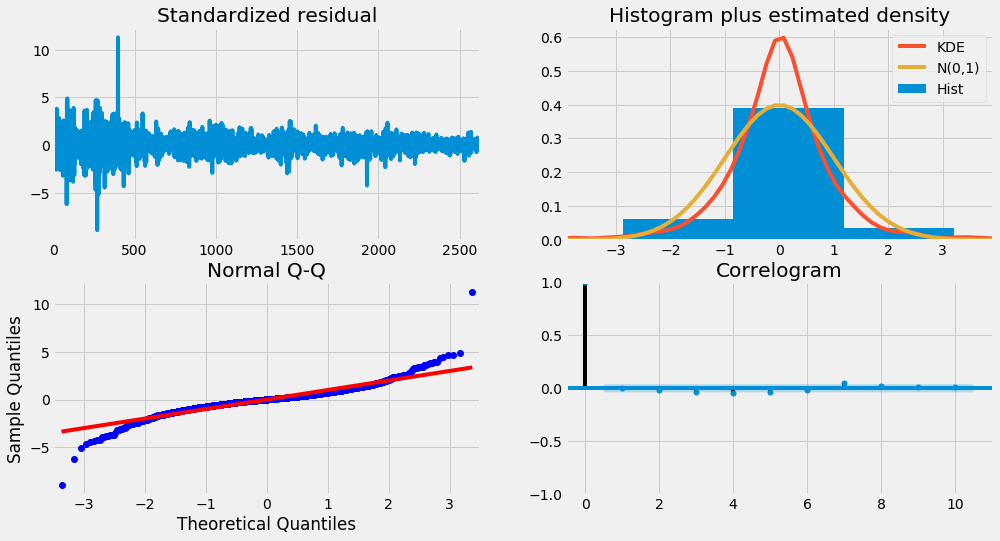

In [0]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [0]:
model = ARIMA(train_data, order=(0, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 2629
Model:                 ARIMA(0, 1, 1)   Log Likelihood                7439.420
Method:                       css-mle   S.D. of innovations              0.014
Date:                Mon, 24 Feb 2020   AIC                         -14872.840
Time:                        11:13:14   BIC                         -14855.217
Sample:                             1   HQIC                        -14866.458
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      1.025      0.305      -0.000       0.001
ma.L1.D.close     0.0794      0.020      4.023      0.000       0.041       0.118
                                    Root

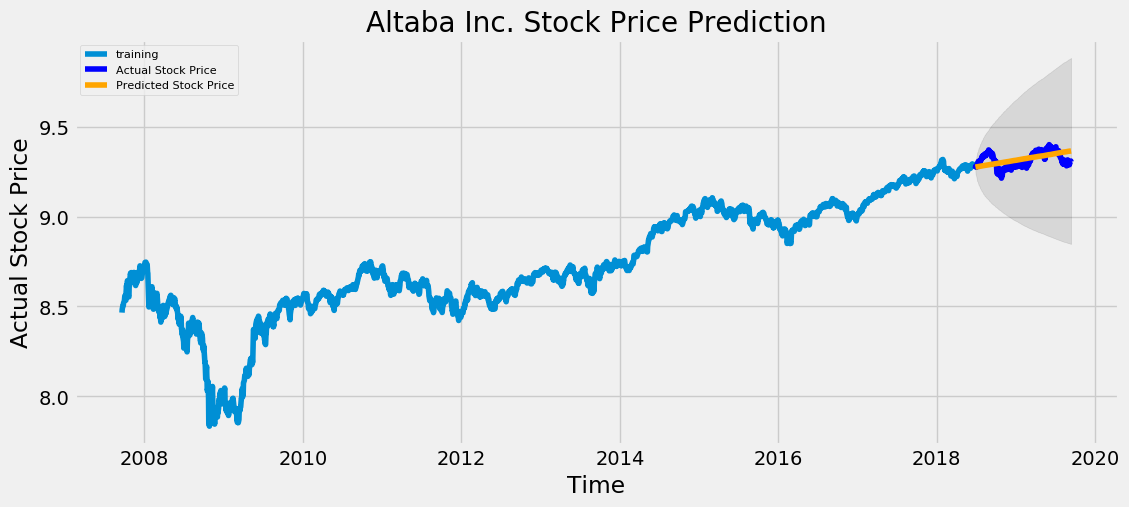

In [0]:
# Forecast
fc, se, conf = fitted.forecast(293, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [0]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.001581730296721256
MAE: 0.034833402558224515
RMSE: 0.03977097304217306


ValueError: ignored

#3 model Prediction
https://towardsdatascience.com/3-time-series-models-anyone-can-build-e6943b017c41

In [0]:
my_stock_bkp = my_stock

In [0]:
my_stock = my_stock_bkp

In [0]:
my_stock = my_stock.reset_index()
my_stock = my_stock.iloc[-98:,:].copy()
#len(my_stock)
my_stock = my_stock.rename({"Date":"ds",my_stock.columns[1]:"y"},axis=1)
#my_stock = my_stock.index.names['ds']
duration = 14
train = my_stock.iloc[:-duration,:].copy()
test = my_stock.iloc[-duration:,:].copy()

In [0]:
train.head()

,ds,y
2963,2019-11-11,11913.45
2964,2019-11-13,11840.45
2965,2019-11-14,11872.10
2966,2019-11-15,11895.45
2967,2019-11-18,11884.50


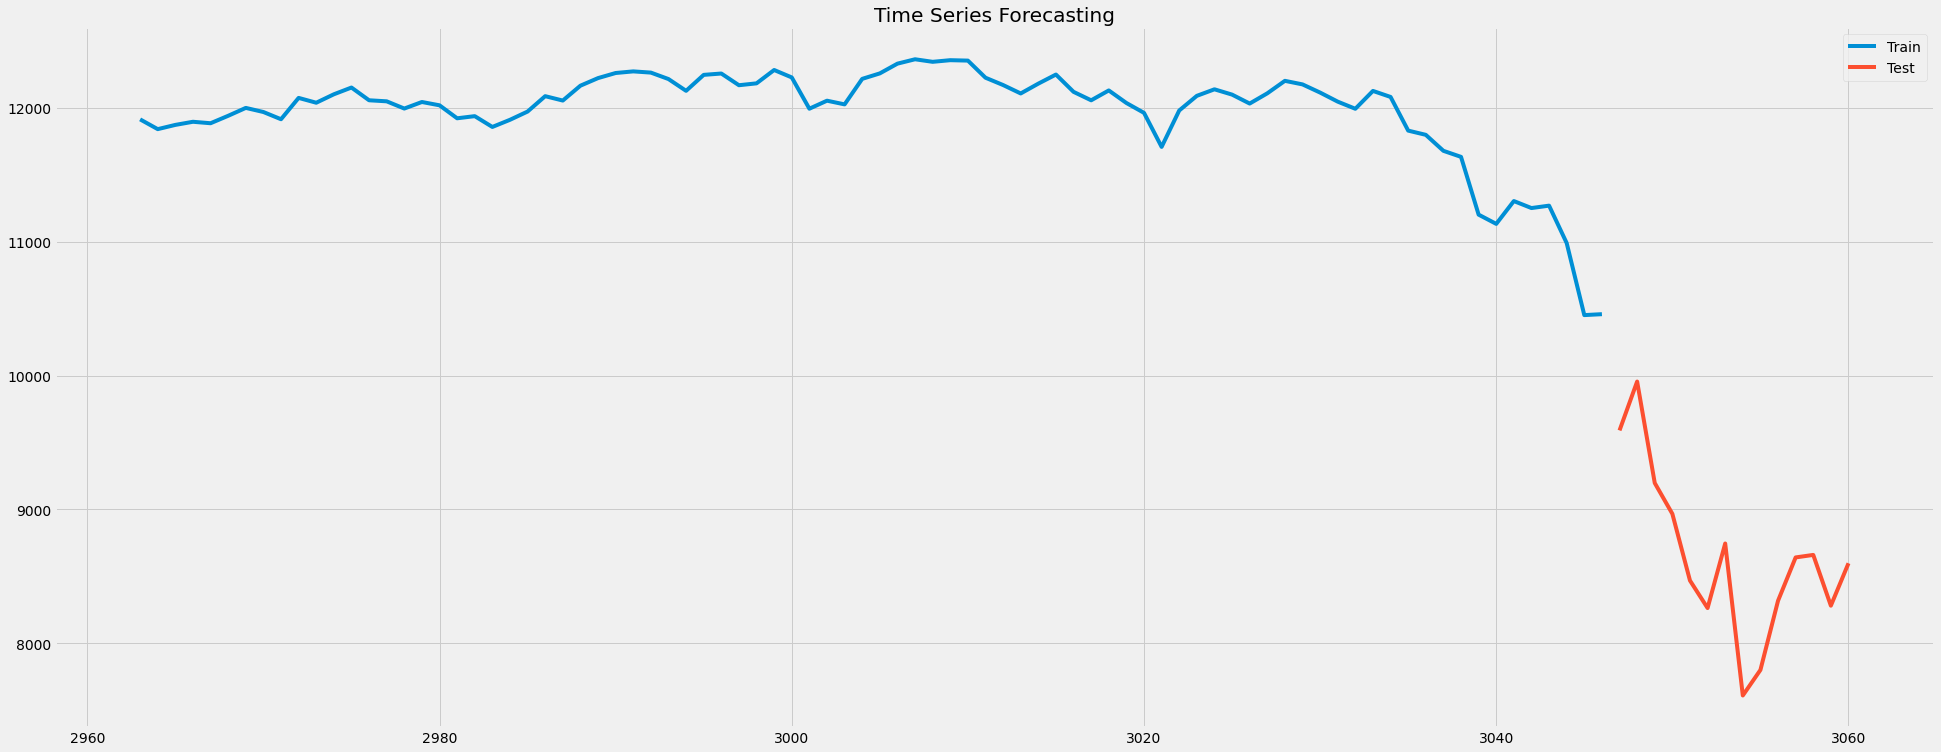

In [0]:
# Visualization
plt.figure(figsize=(30,12))
plt.plot(train["y"],label="Train")
plt.plot(test["y"],label="Test")
plt.title("Time Series Forecasting")
plt.legend()

In [0]:
train.iloc[-1,1]

10458.4

In [0]:
## Persistence algorithm
pred= []
for i in range(duration):
    pred.append(train.iloc[-1,1])    # add test data to train
    train = train.append(test.iloc[i])

In [0]:
pred

[10458.4,
 9590.15,
 9955.2,
 9197.4,
 8967.05,
 8468.8,
 8263.45,
 8745.45,
 7610.25,
 7801.05,
 8317.85,
 8641.45,
 8660.25,
 8281.1]

In [0]:
# Visualization
plt.figure(figsize=(12,12))
plt.plot(train["ds"],train["y"],label="Train")
plt.plot(test["ds"],test["y"],label="Test")
plt.plot(pred,label="Forecast")
plt.title("Time Series Forecasting")
plt.legend()

ValueError: ignored

<Figure size 864x864 with 1 Axes>

In [0]:
from sklearn.metrics import mean_squared_error
rmse =  np.sqrt(mean_squared_error(pred,test["y"]))
print("RMSE:",rmse)

RMSE: 533.080366327898


In [0]:
# Split into train and test set
duration = 14
train = my_stock.iloc[:-duration,:].copy().set_index("ds")
test = my_stock.iloc[-duration:,:].copy().set_index("ds")

In [0]:
train.head()

,y
ds,
2019-11-11,11913.45
2019-11-13,11840.45
2019-11-14,11872.10
2019-11-15,11895.45
2019-11-18,11884.50


In [0]:
import pmdarima as pm

model = pm.auto_arima(train,start_p=0,start_q=0,test="adf",max_p=3,max_q=3,error_action="ignore",suppress_warnings=True,seasonal=False)
# prediction
pred = model.predict(duration)

In [0]:
from sklearn.metrics import mean_squared_error
rmse =  np.sqrt(mean_squared_error(pred,test["y"]))
print("RMSE:",rmse)

RMSE: 1263.6727759916807


In [0]:
# Split into train and test set
duration = 14
train = my_stock.iloc[:-duration,:].copy().set_index("ds")
test = my_stock.iloc[-duration:,:].copy().set_index("ds")

In [0]:
from fbprophet import Prophet
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
# Making prediction
future = model.make_future_dataframe(duration,include_history=False)
pred = model.predict(future)
pred = pred[["yhat","yhat_lower","yhat_upper"]]

In [0]:
from sklearn.metrics import mean_squared_error
rmse =  np.sqrt(mean_squared_error(pred['yhat'],test["y"]))
print("RMSE:",rmse)

RMSE: 9148.163800369368


#Holt Winder Method

In [0]:
from pandas_datareader import data

# Only get the adjusted close.
df = data.DataReader("^NSEI", 
                       start='2000-1-1', 
                       end='2020-04-09', 
                       data_source='yahoo')

In [0]:
import pandas as pd
import numpy as np

In [0]:
df = pd.DataFrame(df['Adj Close']) 


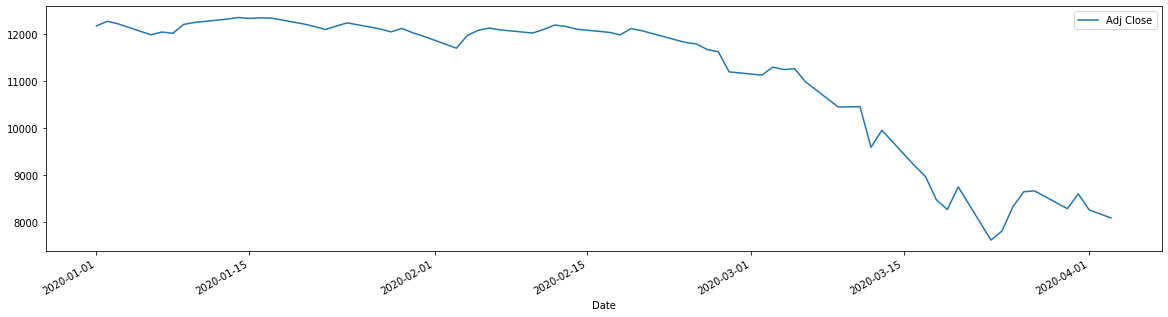

In [0]:
df.plot(figsize=(20,5))

In [0]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [0]:
span = 4
alpha = 2/(span+1)

In [0]:
df['ewm']=df['Adj Close'].ewm(alpha=alpha,adjust=False).mean()

In [0]:
df.plot()

NameError: ignored

In [0]:
model = SimpleExpSmoothing(df['Adj Close'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
fitted_model = model.fit(smoothing_level=alpha,optimized=False)

In [0]:
df['SME'] = fitted_model.fittedvalues.shift(-1)

In [0]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [0]:
model = ExponentialSmoothing(df['Adj Close'],trend='add')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
fitted_model = model.fit()

In [0]:
df['EME'] = fitted_model.fittedvalues.shift(-1)

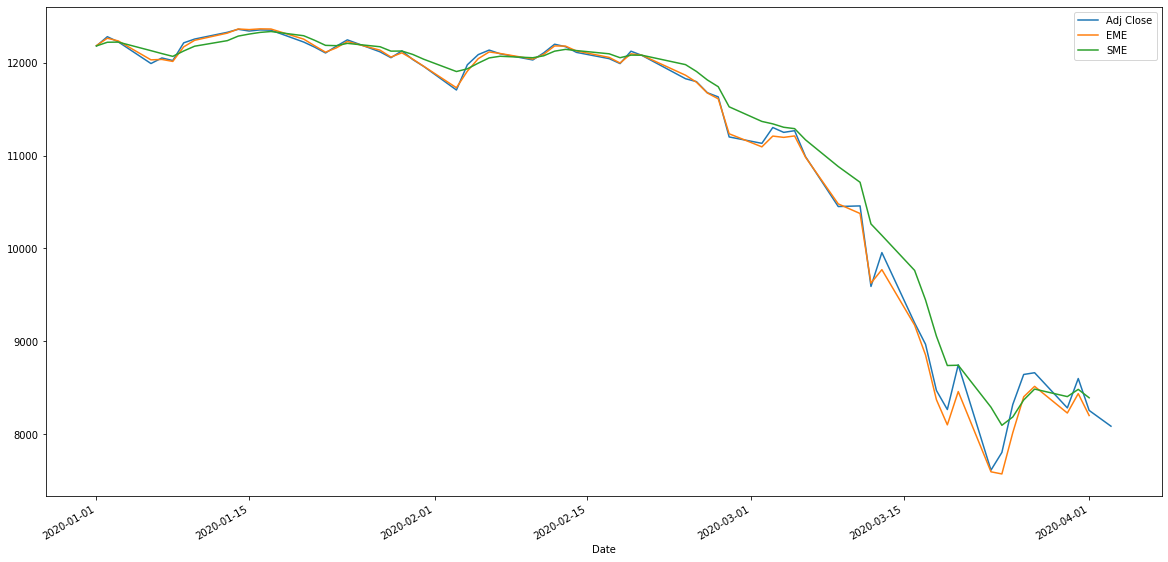

In [0]:
df[['Adj Close','EME','SME']].plot(figsize=(20,10))

In [0]:
model = ExponentialSmoothing(df['Adj Close'],trend='mul', seasonal='mul',seasonal_periods=4)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
fitted_model = model.fit()

In [0]:
df['TES'] = fitted_model.fittedvalues

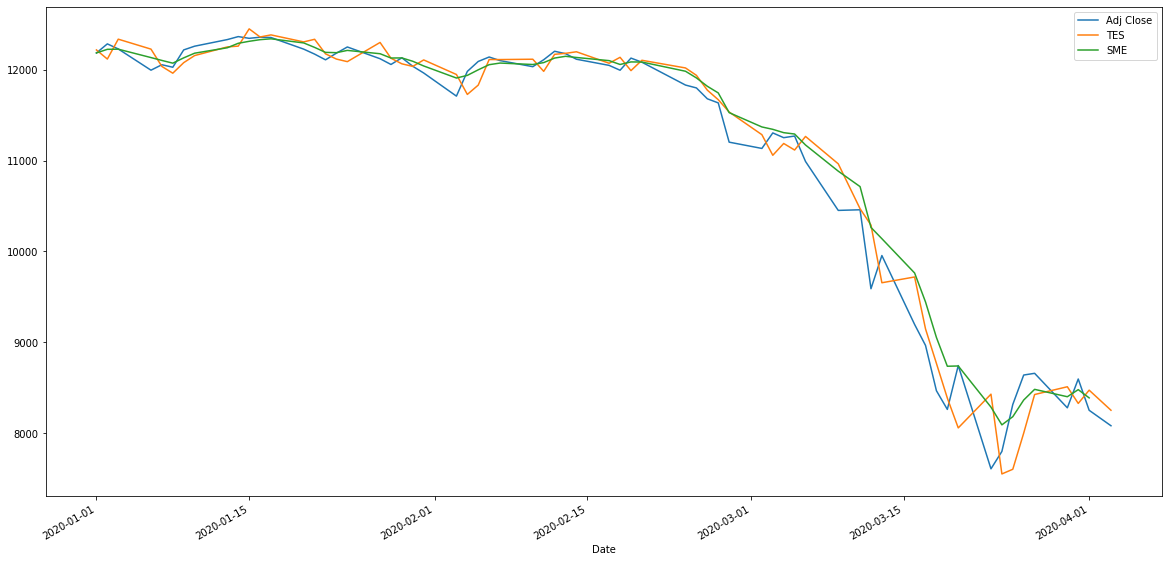

In [0]:
df[['Adj Close','TES','SME']].plot(figsize=(20,10))

# Holt Winder Forecasting


In [0]:
train_data = df.iloc[:2713]
test_data = df.iloc[2713:]
print(len(train_data), len(test_data))

2713 350


In [0]:
df.asfreq(freq ='D')
df.index

DatetimeIndex(['2007-09-17', '2007-09-18', '2007-09-19', '2007-09-20',
               '2007-09-21', '2007-09-24', '2007-09-25', '2007-09-26',
               '2007-09-27', '2007-09-28',
               ...
               '2020-03-20', '2020-03-23', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-27', '2020-03-30', '2020-03-31',
               '2020-04-01', '2020-04-03'],
              dtype='datetime64[ns]', name='Date', length=3063, freq=None)

In [0]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [0]:
model = ExponentialSmoothing(test_data['Adj Close'],trend = 'mul',seasonal='mul',seasonal_periods=5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
fitted_model = model.fit()

In [0]:
#test_prediction = fitted_model.forecast(350)
test_prediction = fitted_model.predict(start=test_data.index[0], end=test_data.index[-1])


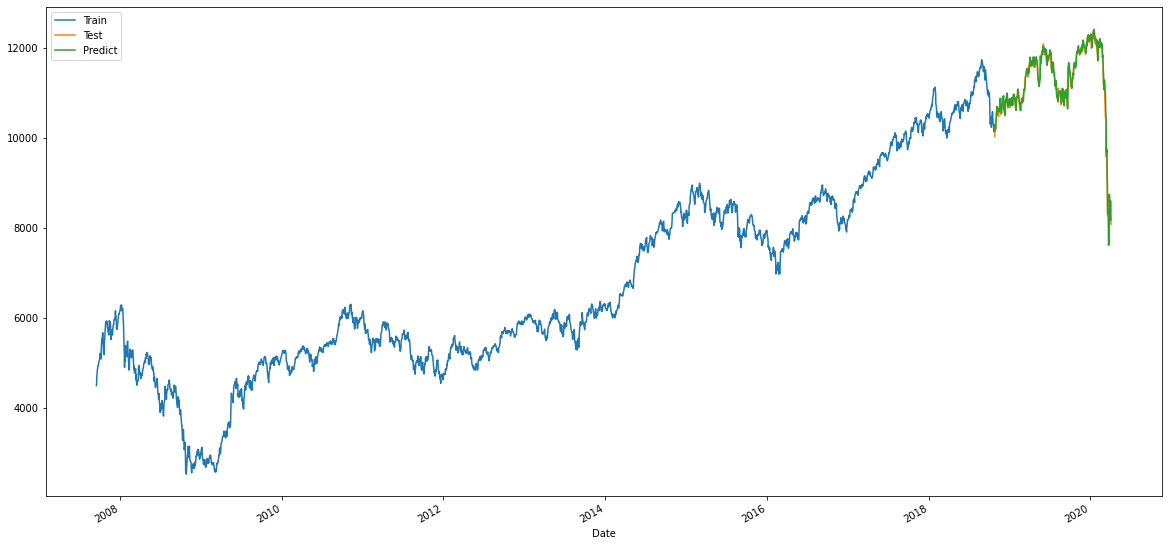

In [0]:
train_data['Adj Close'].plot(legend=True,label='Train',figsize=(20,10))
test_data['Adj Close'].plot(legend=True,label='Test')
test_prediction.plot(legend=True,label='Predict')

In [0]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [0]:
mean_absolute_error(test_data,test_prediction)

99.12280010328404

In [0]:
test_data.describe()

,Adj Close
count,350.000000
mean,11275.539732
std,804.662991
min,7610.250000
25%,10856.300049
50%,11383.525391
75%,11876.112549
max,12362.299805


In [0]:
mean_squared_error(test_data,test_prediction)

22061.009524067056

In [0]:
np.sqrt(mean_squared_error(test_data,test_prediction))

148.52949041879546

#Holt Winder Forecasting for the future

In [0]:
model = ExponentialSmoothing(df['Adj Close'],trend = 'add',seasonal='mul',seasonal_periods=5).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
test = model.predict()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [0]:
df.tail()

,Adj Close
Date,
2020-03-27,8660.250000
2020-03-30,8281.099609
2020-03-31,8597.750000
2020-04-01,8253.799805
2020-04-03,8083.799805


In [0]:
test

3063    8114.472155
dtype: float64

In [0]:
test_forecast = model.forecast(4)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [0]:
test_forecast

3063    8114.472155
3064    7760.368954
3065    7816.942352
3066    7722.669725
dtype: float64

#Stationary Series

In [0]:
from statsmodels.tsa.statespace.tools import diff 


In [0]:
df_diff = diff(df['Adj Close'],k_diff=1)

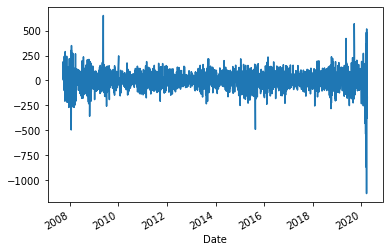

In [0]:
df_diff.plot()

#ACF and PACF

In [0]:
import statsmodels.api as sm

In [0]:
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

In [0]:
df= pd.DataFrame({'a':[13,5,11,12,9]})

In [0]:
acf(df['a'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([ 1.   , -0.5  , -0.2  ,  0.275, -0.075])

In [0]:
pacf_yw(df['a'],nlags=4,method='mle') #max likelihood estimate #youa walker

array([ 1.        , -0.5       , -0.6       , -0.38541667, -0.40563273])

In [0]:
pacf_ols(df['a'],nlags=4)  #ordinary least squar

array([ 1.        , -0.49677419, -0.43181818,  0.53082621,  0.25434783])

In [0]:
from pandas.plotting import lag_plot

In [0]:
df.head()

,a
0,13
1,5
2,11
3,12
4,9


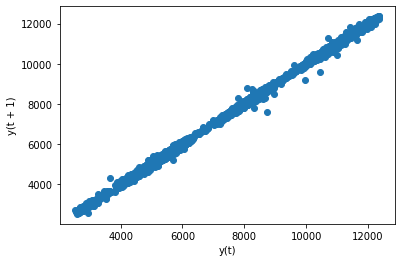

In [0]:
lag_plot(df['Adj Close'])

In [0]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

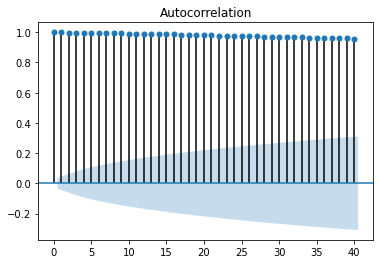

In [0]:
plot_acf(df['Adj Close'],lags=40);

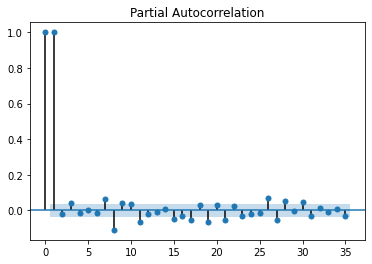

In [0]:
plot_pacf(df['Adj Close']);

#Auto Regressive Model

In [0]:
from statsmodels.tsa.ar_model import AR, ARResults

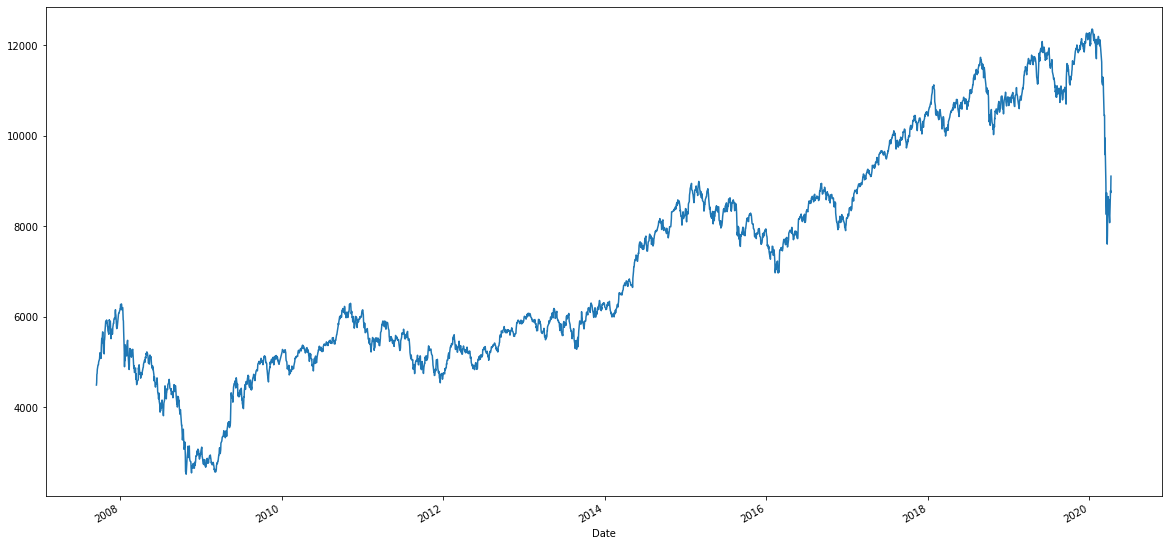

In [5]:
df['Adj Close'].plot(figsize=(20,10))

In [6]:
len(df)

3066

In [0]:
train = df.iloc[:3000]
test = df.iloc[3000:]

In [6]:
model = AR(df['Adj Close'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
AR1fit = model.fit(maxlag=1)

In [16]:
AR1fit.k_ar

1

In [17]:
AR1fit.params

const           6.936553
L1.Adj Close    0.999248
dtype: float64

In [0]:
start = len(train)

In [0]:
end = len(train) + len(test) -1

In [10]:
print(start,end)

3000 3065


In [11]:
AR1fit.predict(start=start,end=end)

Date
2020-01-03    12279.898740
2020-01-06    12224.390717
2020-01-07    11990.965833
2020-01-08    12050.821170
2020-01-09    12023.241344
                  ...     
2020-04-01     8598.219789
2020-04-03     8254.528295
2020-04-07     8084.656160
2020-04-08     8792.523730
2020-04-09     8749.106215
Length: 66, dtype: float64

In [0]:
predictions1 = AR1fit.predict(start=start,end=end)

In [0]:
predictions1 = predictions1.rename('AR(1) Pred')

In [24]:
predictions1

Date
2007-12-20    5753.760751
2007-12-24    5769.099303
2007-12-26    5987.534981
2007-12-27    6073.120462
2007-12-28    6083.862377
                 ...     
2020-04-01    8598.219789
2020-04-03    8254.528295
2020-04-07    8084.656160
2020-04-08    8792.523730
2020-04-09    8749.106215
Name: AR(1) Pred, Length: 3000, dtype: float64

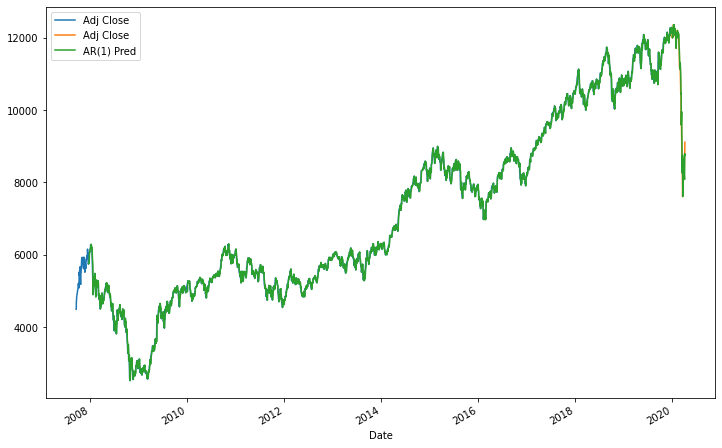

In [29]:
test['Adj Close'].plot(figsize=(12,8),legend=True)
train['Adj Close'].plot(legend=True)
predictions1.plot(legend=True)

In [0]:
AR2fit = model.fit(maxlag=2)

In [0]:
prediction2 =  AR2fit.predict(start=start,end=end)

In [0]:
prediction2 = prediction2.rename('AR(2) pred')

In [36]:
print(start,end)

66 3065


In [41]:
AR2fit.params

const           6.910133
L1.Adj Close    1.016653
L2.Adj Close   -0.017407
dtype: float64

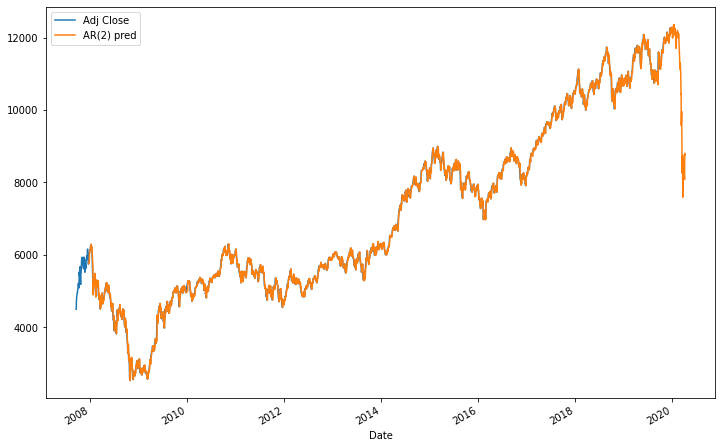

In [38]:
test['Adj Close'].plot(figsize=(12,8),legend=True)
#train['Adj Close'].plot(legend=True)
prediction2.plot(legend=True)

In [0]:
ARFit = model.fit(ic='t-stat')

In [20]:
ARFit.params

const            5.677630
L1.Adj Close     1.035176
L2.Adj Close    -0.004624
L3.Adj Close    -0.041768
L4.Adj Close     0.011000
L5.Adj Close     0.035458
L6.Adj Close    -0.126212
L7.Adj Close     0.194742
L8.Adj Close    -0.108313
L9.Adj Close    -0.003231
L10.Adj Close    0.086974
L11.Adj Close   -0.123338
L12.Adj Close    0.083528
L13.Adj Close   -0.071812
L14.Adj Close    0.022567
L15.Adj Close    0.056519
L16.Adj Close   -0.058532
L17.Adj Close    0.017170
L18.Adj Close   -0.024479
L19.Adj Close    0.016532
L20.Adj Close   -0.002325
L21.Adj Close   -0.041407
L22.Adj Close    0.038488
L23.Adj Close    0.017654
L24.Adj Close   -0.008535
L25.Adj Close   -0.022482
L26.Adj Close    0.030860
L27.Adj Close   -0.051459
L28.Adj Close    0.041232
dtype: float64

In [0]:
prediction_auto = ARFit.predict(start=start,end=end)

In [46]:
type(prediction_auto)

pandas.core.series.Series

In [0]:
prediction_auto = prediction_auto.rename('Auto')

In [49]:
prediction_auto

Date
2007-12-20    5763.231785
2007-12-24    5785.382271
2007-12-26    5970.048476
2007-12-27    6110.552371
2007-12-28    6064.999319
                 ...     
2020-04-01    8425.572641
2020-04-03    8220.306529
2020-04-07    8176.918673
2020-04-08    8701.204566
2020-04-09    8938.410381
Name: Auto, Length: 3000, dtype: float64

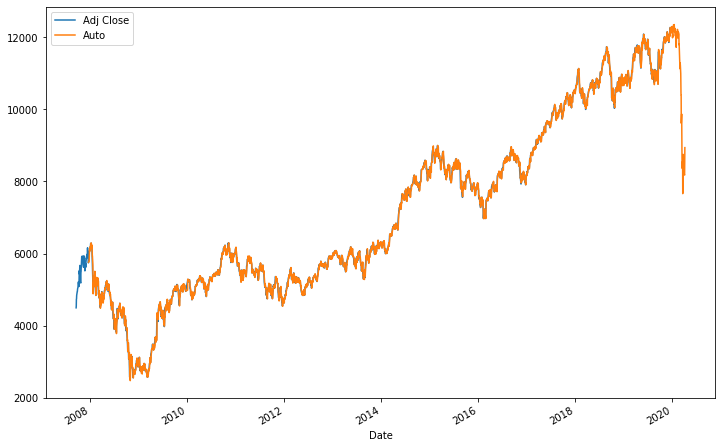

In [48]:
test['Adj Close'].plot(figsize=(12,8),legend=True)
#train['Adj Close'].plot(legend=True)
prediction_auto.plot(legend=True)

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
labels = ['AR1fit','AR2fit','ARFit']

In [0]:
pred = [predictions1,prediction2,prediction_auto]

In [23]:
for i in range(3):
  error = mean_squared_error(test['Adj Close'],pred[i])
  print(f'{labels[i]} MSE is : {error}')


AR1fit MSE is : 87984.30594421536
AR2fit MSE is : 88512.85445948433
ARFit MSE is : 69686.48284981652


In [24]:
ARFitFull = model.fit()

ARFitFull.predict(start=len(df),end=len(df)+5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3066    9017.011147
3067    9145.824136
3068    9214.487891
3069    9051.030787
3070    9228.478422
3071    9160.056669
dtype: float64

#Descriptive Statistics

In [0]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [30]:
adf_test(df['Adj Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.153433
p-value                    0.693300
# lags used               15.000000
# observations          3050.000000
critical value (1%)       -3.432496
critical value (5%)       -2.862488
critical value (10%)      -2.567275
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [0]:
from statsmodels.tsa.stattools import grangercausalitytests

In [34]:
grangercausalitytests(df[['Close','Adj Close']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=3063, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=2357197.9025, p=0.0000  , df_denom=3063, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=3061, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=1177844.8916, p=0.0000  , df_denom=3061, df_num=2


{1: ({'lrtest': (-0.0, 1.0, 1),
   'params_ftest': (2357197.9024942773, 0.0, 3063.0, 1.0),
   'ssr_chi2test': (-1.414188240835544e-12, 1.0, 1),
   'ssr_ftest': (-1.4132654426359776e-12, 1.0, 3063.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (-0.0, 1.0, 2),
   'params_ftest': (1177844.8916187962, 0.0, 3061.0, 2.0),
   'ssr_chi2test': (0.0, 1.0, 2),
   'ssr_ftest': (0.0, 1.0, 3061.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [0]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

In [0]:
dfm = df['Adj Close'].resample(rule='M').mean()

In [44]:
type(dfm)

pandas.core.series.Series

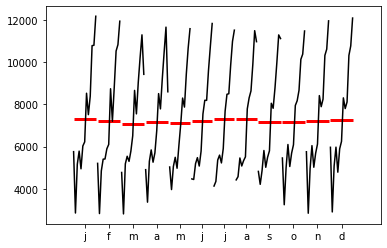

In [46]:
month_plot(dfm);

#Auto Arima

In [47]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.5MB/s 


In [0]:
from pmdarima import auto_arima

In [58]:
setupwise_fit = auto_arima(df['Adj Close'], start_p=0, start_q=0, max_p=6, max_q=6, seasonal=True, trace=True, m=5)
#m is number of periods for the season. choose 5 for weekly


Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(1, 0, 1, 5) (constant=True); AIC=36195.095, BIC=36219.206, Time=2.814 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 5) (constant=True); AIC=36211.671, BIC=36223.727, Time=0.112 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 5) (constant=True); AIC=36207.227, BIC=36231.338, Time=0.836 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 5) (constant=True); AIC=36208.398, BIC=36232.509, Time=0.721 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 5) (constant=False); AIC=36210.551, BIC=36216.579, Time=0.058 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 1, 5) (constant=True); AIC=36207.703, BIC=36225.786, Time=0.738 seconds
Fit ARIMA: (0, 1, 0)x(1, 0, 0, 5) (constant=True); AIC=36206.733, BIC=36224.816, Time=0.430 seconds
Fit ARIMA: (0, 1, 0)x(2, 0, 1, 5) (constant=True); AIC=36187.949, BIC=36218.088, Time=5.513 seconds
Fit ARIMA: (0, 1, 0)x(2, 0, 0, 5) (constant=True); AIC=36188.244, BIC=36212.355, Time=2.885 seconds
Fit ARIMA: (0, 1, 0)x(2, 0, 2, 5) (constant=True); AIC=3

In [59]:
setupwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3066
Model:             SARIMAX(2, 1, 0)x(1, 0, 2, 5)   Log Likelihood              -18085.858
Date:                           Fri, 10 Apr 2020   AIC                          36185.716
Time:                                   08:44:25   BIC                          36227.911
Sample:                                        0   HQIC                         36200.877
                                          - 3066                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0155      1.318      0.770      0.441      -1.569       3.600
ar.L1          0.0259      0.010      2.616      0.009       0.007       0.045
ar.L2          0.0319      0.008      4.213      0.000       0.017       0.047
ar.S.L5        0.3560      0.137      2.595      0.009       0.087       0.625
ma.S.L5       -0.3151      0.139     -2.268      0.023      -0.587      -0.043
ma.S.L10       0.0761      0.014      5.263      0.000       0.048       0.104
sigma2      7809.2963     87.962     88.781      0.000    7636.895    7981.698
===================================================================================
Ljung-Box (Q):                       91.35   Jarque-Bera (JB):             31994.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#ARMA

In [0]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults

In [0]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [0]:
from pmdarima import auto_arima

In [63]:
adf_test(df['Adj Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.153433
p-value                    0.693300
# lags used               15.000000
# observations          3050.000000
critical value (1%)       -3.432496
critical value (5%)       -2.862488
critical value (10%)      -2.567275
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [64]:
auto_arima(df['Adj Close'],seasonal=False).summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3066
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -18057.155
Date:                Fri, 10 Apr 2020   AIC                          36132.310
Time:                        09:21:22   BIC                          36186.561
Sample:                             0   HQIC                         36151.803
                               - 3066                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3516      5.489      0.246      0.805      -9.406      12.110
ar.L1         -1.3245      0.039    -33.542      0.000      -1.402      -1.247
ar.L2         -0.7002      0.034    -20.741      0.000      -0.766      -0.634
ar.L3          0.0565      0.019      2.927      0.003       0.019       0.094
ar.L4          0.0157      0.018      0.881      0.379      -0.019       0.051
ar.L5          0.0656      0.013      5.199      0.000       0.041       0.090
ma.L1          1.3621      0.037     36.697      0.000       1.289       1.435
ma.L2          0.7826      0.029     26.580      0.000       0.725       0.840
sigma2      7673.3841     96.449     79.559      0.000    7484.347    7862.421
===================================================================================
Ljung-Box (Q):                       35.16   Jarque-Bera (JB):             24481.84
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
from statsmodels.tsa.statespace.tools import diff

In [0]:
df_1 = diff(df['Adj Close'],k_diff=1)

In [67]:
adf_test(df_1)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.298321e+01
p-value                 2.914424e-24
# lags used             1.400000e+01
# observations          3.050000e+03
critical value (1%)    -3.432496e+00
critical value (5%)    -2.862488e+00
critical value (10%)   -2.567275e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [68]:
len(df)

3066

In [0]:
train = df[:3000]
test = df[3000:]

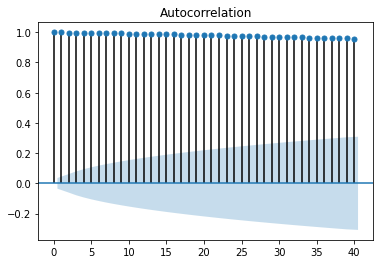

In [75]:
plot_acf(df['Adj Close'],lags=40);

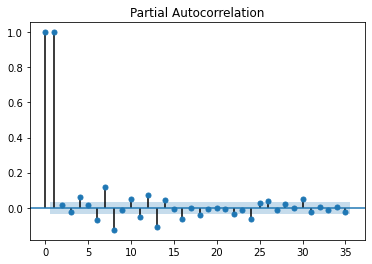

In [74]:
plot_pacf(df['Adj Close']);

In [76]:
model = ARIMA(train['Adj Close'],order=(5,1,2))
results=model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overf

In [78]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                 2999
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -17316.804
Method:                       css-mle   S.D. of innovations             77.885
Date:                Fri, 10 Apr 2020   AIC                          34651.609
Time:                        09:36:00   BIC                          34705.663
Sample:                             1   HQIC                         34671.052
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.5925      1.443      1.796      0.073      -0.236       5.421
ar.L1.D.Adj Close     1.4146      0.048     29.577      0.000       1.321       1.508
ar.L2.D.Adj Close    -1.0607      0.045    -23.549      0.000      -1.149      -0.972
ar.L3.D.Adj Close     0.0421      0.037      1.132      0.258      -0.031       0.115
ar.L4.D.Adj Close     0.0286      0.032      0.895      0.371      -0.034       0.091
ar.L5.D.Adj Close    -0.0325      0.020     -1.640      0.101      -0.071       0.006
ma.L1.D.Adj Close    -1.3442      0.044    -30.355      0.000      -1.431      -1.257
ma.L2.D.Adj Close     0.9612      0.029     32.620      0.000       0.903       1.019
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7013           -0.7338j            1.0150           -0.1286
AR.2            0.7013           +0.7338j            1.0150            0.1286
AR.3           -3.4658           -0.0000j            3.4658           -0.5000
AR.4            1.4707           -2.5386j            2.9338           -0.1664
AR.5            1.4707           +2.5386j            2.9338            0.1664
MA.1            0.6992           -0.7426j            1.0200           -0.1298
MA.2            0.6992           +0.7426j            1.0200            0.1298
-----------------------------------------------------------------------------
"""

In [0]:
start=len(train)
end=len(train) + len(test)-1

In [82]:
prediction_arima=results.predict(start,end,typ='levels')#typ default will return diff values levels will give actual values

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [83]:
prediction_arima

2999    12293.371719
3000    12299.062091
3001    12304.276669
3002    12310.054761
3003    12311.587882
            ...     
3060    12450.063683
3061    12452.485429
3062    12456.806337
3063    12461.917656
3064    12466.261536
Length: 66, dtype: float64

In [84]:
train.head()

,Adj Close
Date,
2007-09-17,4494.649902
2007-09-18,4546.200195
2007-09-19,4732.350098
2007-09-20,4747.549805
2007-09-21,4837.549805


In [0]:
from statsmodels.tools.eval_measures import rmse

In [86]:
rmse(test['Adj Close'],prediction_arima)

2137.2658216214095

Forecaste future

In [87]:
model = ARIMA(df['Adj Close'],order=(5,1,2))
results= model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [92]:
results.predict(start = len(df), end = len(df)+5, typ='levels')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3065    9008.674483
3066    9051.716222
3067    9137.263652
3068    8994.759697
3069    9152.370568
3070    9046.649939
dtype: float64